<a href="https://colab.research.google.com/github/Jorgecuenca1/trabajo-vision-computadora-ii/blob/main/trabajo%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

El proceso de Data Augmentation consiste en realizar diversas transformaciones sobre los datos de entrada con el objetivo de aportar variabilidad e incrementar el tamaño de mi conjunto de datos, partiendo de los datos ya existentes y etiquetados. Dichas transformaciones puede ser, como vimos en teoria, de distintos tipos, sin embargo, es necesario tener en cuenta solo utilizar las que sean coherentes con el problema puntual sobre el que estamos trabajando.

Para este ejercicio vamos a trabajar con un dataset de imágenes de perros y gatos, el cual contiene 4000 imagenes a color, 2000 de perros y 2000 de gatos. Dichas imágenes ya se encuentran divididas en 3 carpetas correspondientes a entrenamiento, validación y testeo con 2000, 1000 y 1000 imágenes en cada una, respectivamente.

Podemos descargar el dataset al entorno de trabajo, desde una carpeta de Drive a partir de utilizar el ID del archivo dentro de Drive.

In [3]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics

from torch.utils.tensorboard import SummaryWriter

In [4]:
# https://drive.google.com/file/d/1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-/view?usp=sharing
# El ID sera: 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
!gdown --id 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
From (redirected): https://drive.google.com/uc?id=1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-&confirm=t&uuid=0381ba3c-83c5-4574-bdc9-ca30a87e0a91
To: /content/perros_y_gatos.zip
100% 90.8M/90.8M [00:02<00:00, 38.4MB/s]


## Visualización de los datos

A partir de observar las distintas imágenes, podemos notar que no todas conservan las mismas dimensiones, por lo que será necesario realizar un redimensionamiento de forma tal que queden uniformes para un posible entrenamiento con capas convolucionales.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


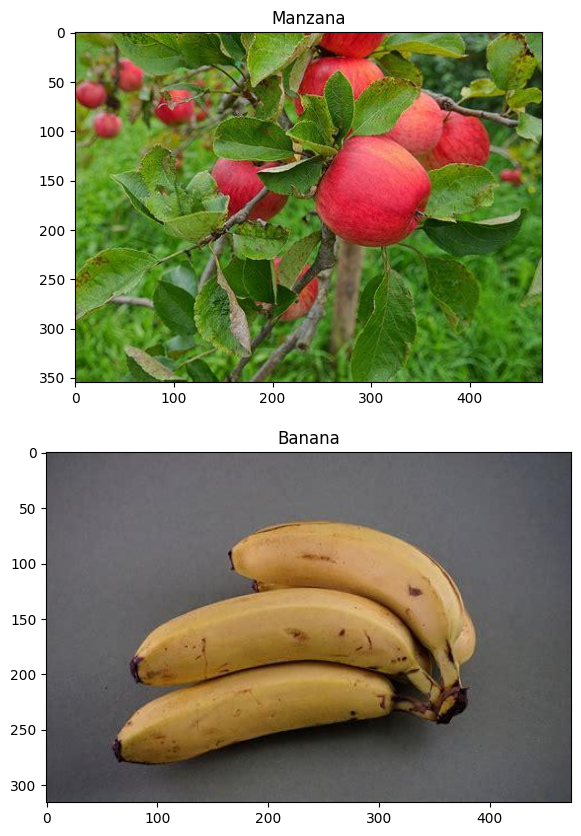

In [6]:
apple_image_name = random.choice(os.listdir("/content/drive/MyDrive/train/apple"))
apple_image = mpimg.imread(os.path.join("/content/drive/MyDrive/train/apple", apple_image_name))
banana_image_name = random.choice(os.listdir("/content/drive/MyDrive/train/banana"))
banana_image = mpimg.imread(os.path.join("/content/drive/MyDrive/train/banana", banana_image_name))

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].imshow(apple_image)
axs[0].title.set_text('Manzana')

axs[1].imshow(banana_image)
axs[1].title.set_text('Banana')


## Utilizar los datos

Para consumir los datos con nuestro modelo vamos a utilizar objetos de la clase DataLoader. Tambien, para poder cargar imágenes propias utilizamos la clase [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder#torchvision.datasets.ImageFolder), a la cual le pasamos el directorio donde se encuentran las imágenes a partir del cual infiere las clases dentro del dataset. Para mas información respecto a este punto ver [aquí](https://pytorch.org/vision/stable/generated/torchvision.datasets.DatasetFolder.html#torchvision.datasets.DatasetFolder).

In [7]:
CANTIDAD_CLASES = 5
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [8]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/train/', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/validation/', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

Ahora defino una red neuronal contemplando la opción de que, si existe una GPU, se mueva la red allí para optimizar el entrenamiento.

In [9]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                    [-1, 5]           2,565
Total params: 5,408,933
Trainable params: 5,408,933
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.63
Estima

In [10]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [11]:
# Imprimir algunas etiquetas del conjunto de entrenamiento
for images, labels in train_loader:
    print(labels)
    break


tensor([0, 1, 0, 4, 4, 4, 2, 0, 4, 3, 2, 3, 3, 1, 0, 3, 1, 3, 3, 0, 3, 1, 4, 1,
        1, 2, 4, 1, 4, 0, 3, 0])


In [12]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.0001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                20,
                noaug_writer)

Epoch: 1/20 - Train loss 1.305170 - Train Accuracy 0.450581 - Valid Loss 1.049699 - Valid Accuracy 0.581473
Epoch: 2/20 - Train loss 0.928262 - Train Accuracy 0.638669 - Valid Loss 0.844910 - Valid Accuracy 0.648661
Epoch: 3/20 - Train loss 0.796619 - Train Accuracy 0.694584 - Valid Loss 0.718009 - Valid Accuracy 0.734598
Epoch: 4/20 - Train loss 0.692012 - Train Accuracy 0.739221 - Valid Loss 0.627490 - Valid Accuracy 0.776339
Epoch: 5/20 - Train loss 0.607647 - Train Accuracy 0.779191 - Valid Loss 0.536110 - Valid Accuracy 0.807254
Epoch: 6/20 - Train loss 0.494767 - Train Accuracy 0.826885 - Valid Loss 0.463217 - Valid Accuracy 0.816295
Epoch: 7/20 - Train loss 0.382235 - Train Accuracy 0.871356 - Valid Loss 0.385207 - Valid Accuracy 0.867857
Epoch: 8/20 - Train loss 0.292958 - Train Accuracy 0.911070 - Valid Loss 0.238197 - Valid Accuracy 0.946094
Epoch: 9/20 - Train loss 0.200787 - Train Accuracy 0.946067 - Valid Loss 0.185891 - Valid Accuracy 0.941406
Epoch: 10/20 - Train loss 0.

Realizo gráficas del resultado del entrenamiento para visualizar el comportamiento de las métricas a lo largo de las epocas.

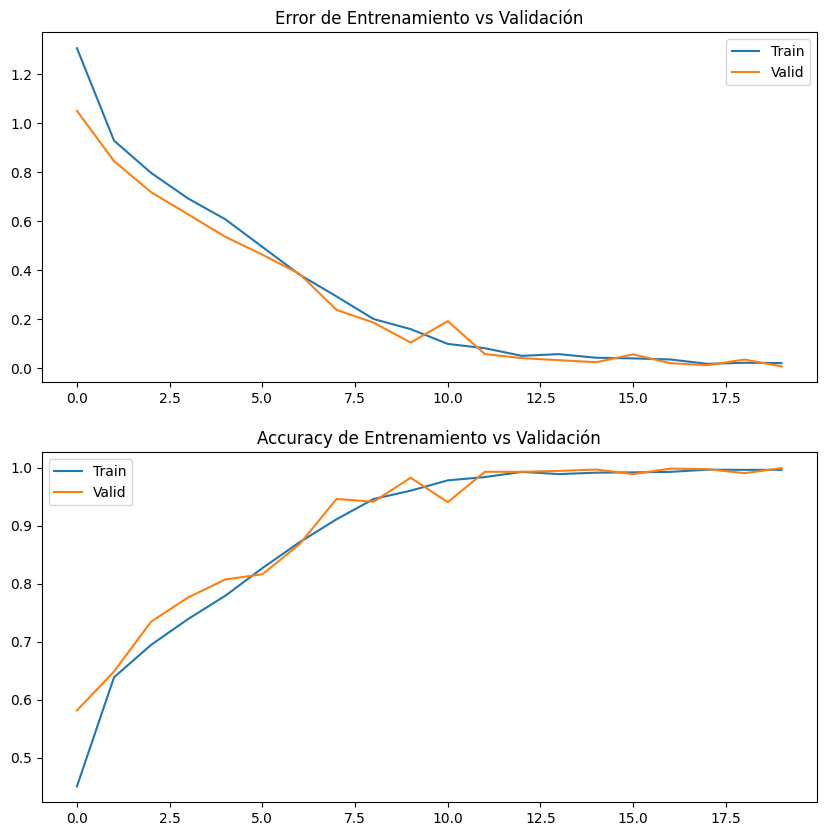

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Su puede observar una clara tendencia al sobreentrenamiento del modelo, el cual es debido a, entre otras cosas, la poca cantidad de datos de entrenamiento utilizados.

---
## Aplicar Data Augmentation

Para aplicar Data Augmentation sobre los datos vamos a utilizar la misma composición de transformaciones que ya veniamos utilizando. Allí podemos agregar una serie de funciones listadas [`aquí`](https://pytorch.org/vision/stable/transforms.html). Para ver ejemplos de dichas transformaciones ver [este](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) link.

Ademas de las transformaciones implementadas dentro del modulo `torchvision` de Pytorch, podemos optar por utilizar librerias externas para dicho proposito e integrar sus transformaciones en el pipeline de entrenamiento de Pytorch.

In [14]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

aug_train_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/train', transform=aug_data_transforms)
aug_valid_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/validation', transform=data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)

Podemos visualizar el resultado de aplicar dichas transformaciones sobre las imágenes de nuestro dataset. Para ello debemos revertir la normalización aplicada por las transformaciones. Aquí el metodo [`permute`](https://pytorch.org/docs/stable/generated/torch.permute.html#torch.permute) nos permite reordenar las dimensiones del tensor de (3, 150, 150) a (150, 150, 3).

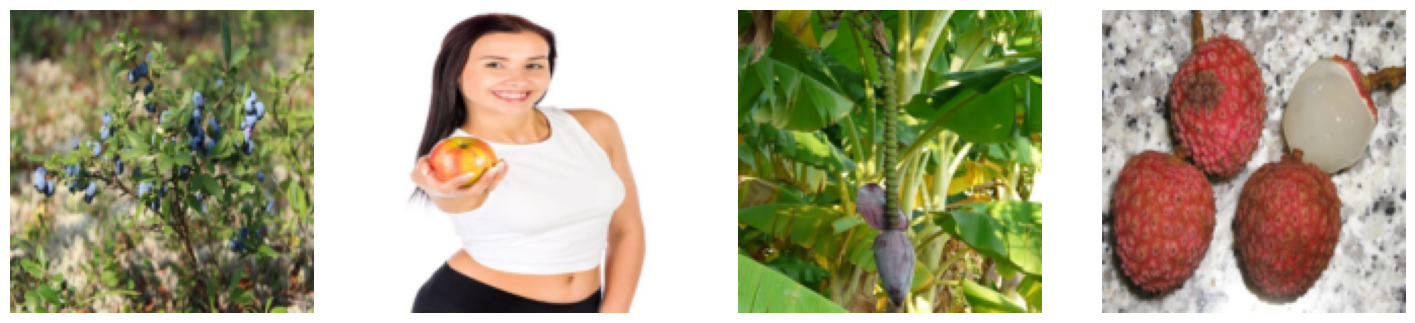

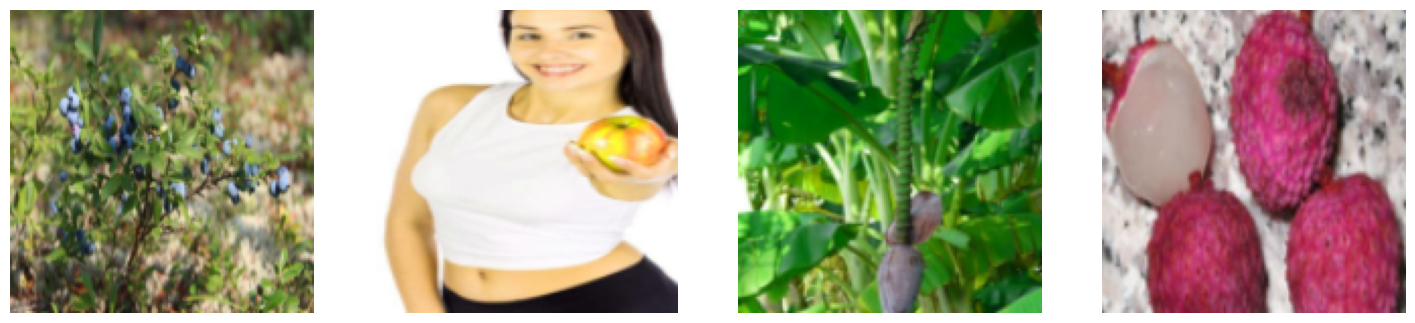

In [15]:
images_ids = np.random.randint(low=0, high=len(train_set), size=4)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

Si ahora, repito el proceso de entrenamiento, utilizando la misma arquitectura de red neuronal del caso anterior, pero pasandole datos sobre los que realizo las perturbaciones antes definidas, mi entrenamiento deberia ser más estable aunque un poco mas lento.

In [16]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.0001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                10,
                aug_writer)

Epoch: 1/10 - Train loss 1.353099 - Train Accuracy 0.417924 - Valid Loss 1.190211 - Valid Accuracy 0.503795
Epoch: 2/10 - Train loss 1.147538 - Train Accuracy 0.533219 - Valid Loss 1.031919 - Valid Accuracy 0.574777
Epoch: 3/10 - Train loss 1.074115 - Train Accuracy 0.565032 - Valid Loss 0.976951 - Valid Accuracy 0.615848
Epoch: 4/10 - Train loss 1.039723 - Train Accuracy 0.580887 - Valid Loss 0.939100 - Valid Accuracy 0.623326
Epoch: 5/10 - Train loss 1.009476 - Train Accuracy 0.593712 - Valid Loss 0.872809 - Valid Accuracy 0.652567
Epoch: 6/10 - Train loss 0.981072 - Train Accuracy 0.600182 - Valid Loss 0.873549 - Valid Accuracy 0.653013
Epoch: 7/10 - Train loss 0.938201 - Train Accuracy 0.620039 - Valid Loss 0.839712 - Valid Accuracy 0.674554
Epoch: 8/10 - Train loss 0.912223 - Train Accuracy 0.627353 - Valid Loss 0.805327 - Valid Accuracy 0.689621
Epoch: 9/10 - Train loss 0.906013 - Train Accuracy 0.637006 - Valid Loss 0.788338 - Valid Accuracy 0.690067
Epoch: 10/10 - Train loss 0.

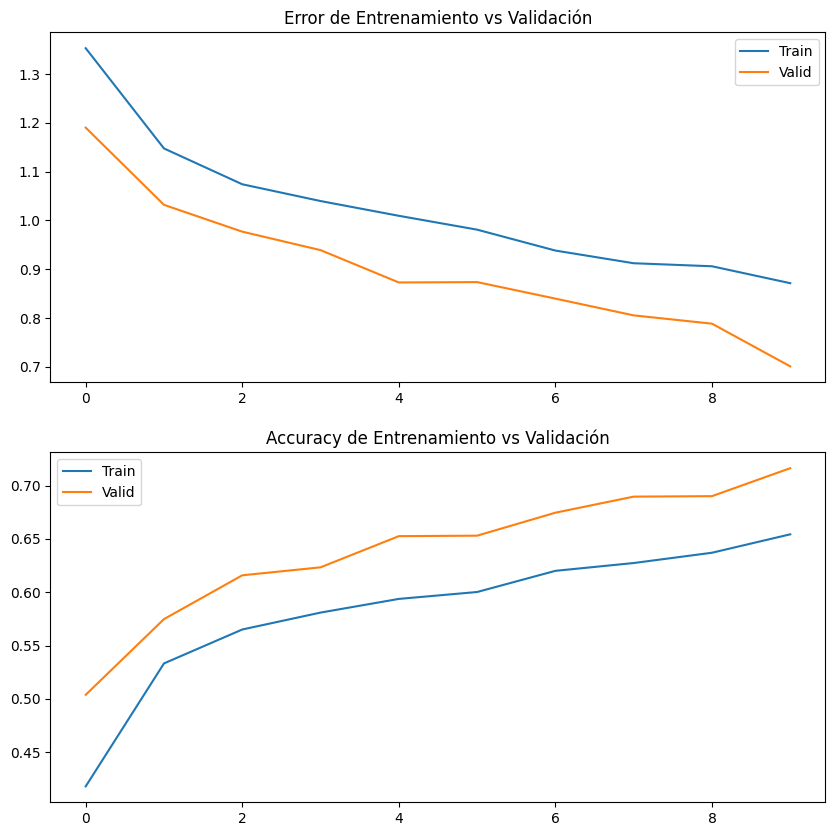

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
train_loss1=history["train_loss"]
valid_loss1=history["valid_loss"]
train_loss1=history["train_acc"]
valid_loss1=history["valid_loss"]
axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

AHORA INICIO CON RESNET


In [18]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

In [20]:
CANTIDAD_CLASES = 10
ANCHO_IMAGENES = 32
ALTO_IMAGENES = 32

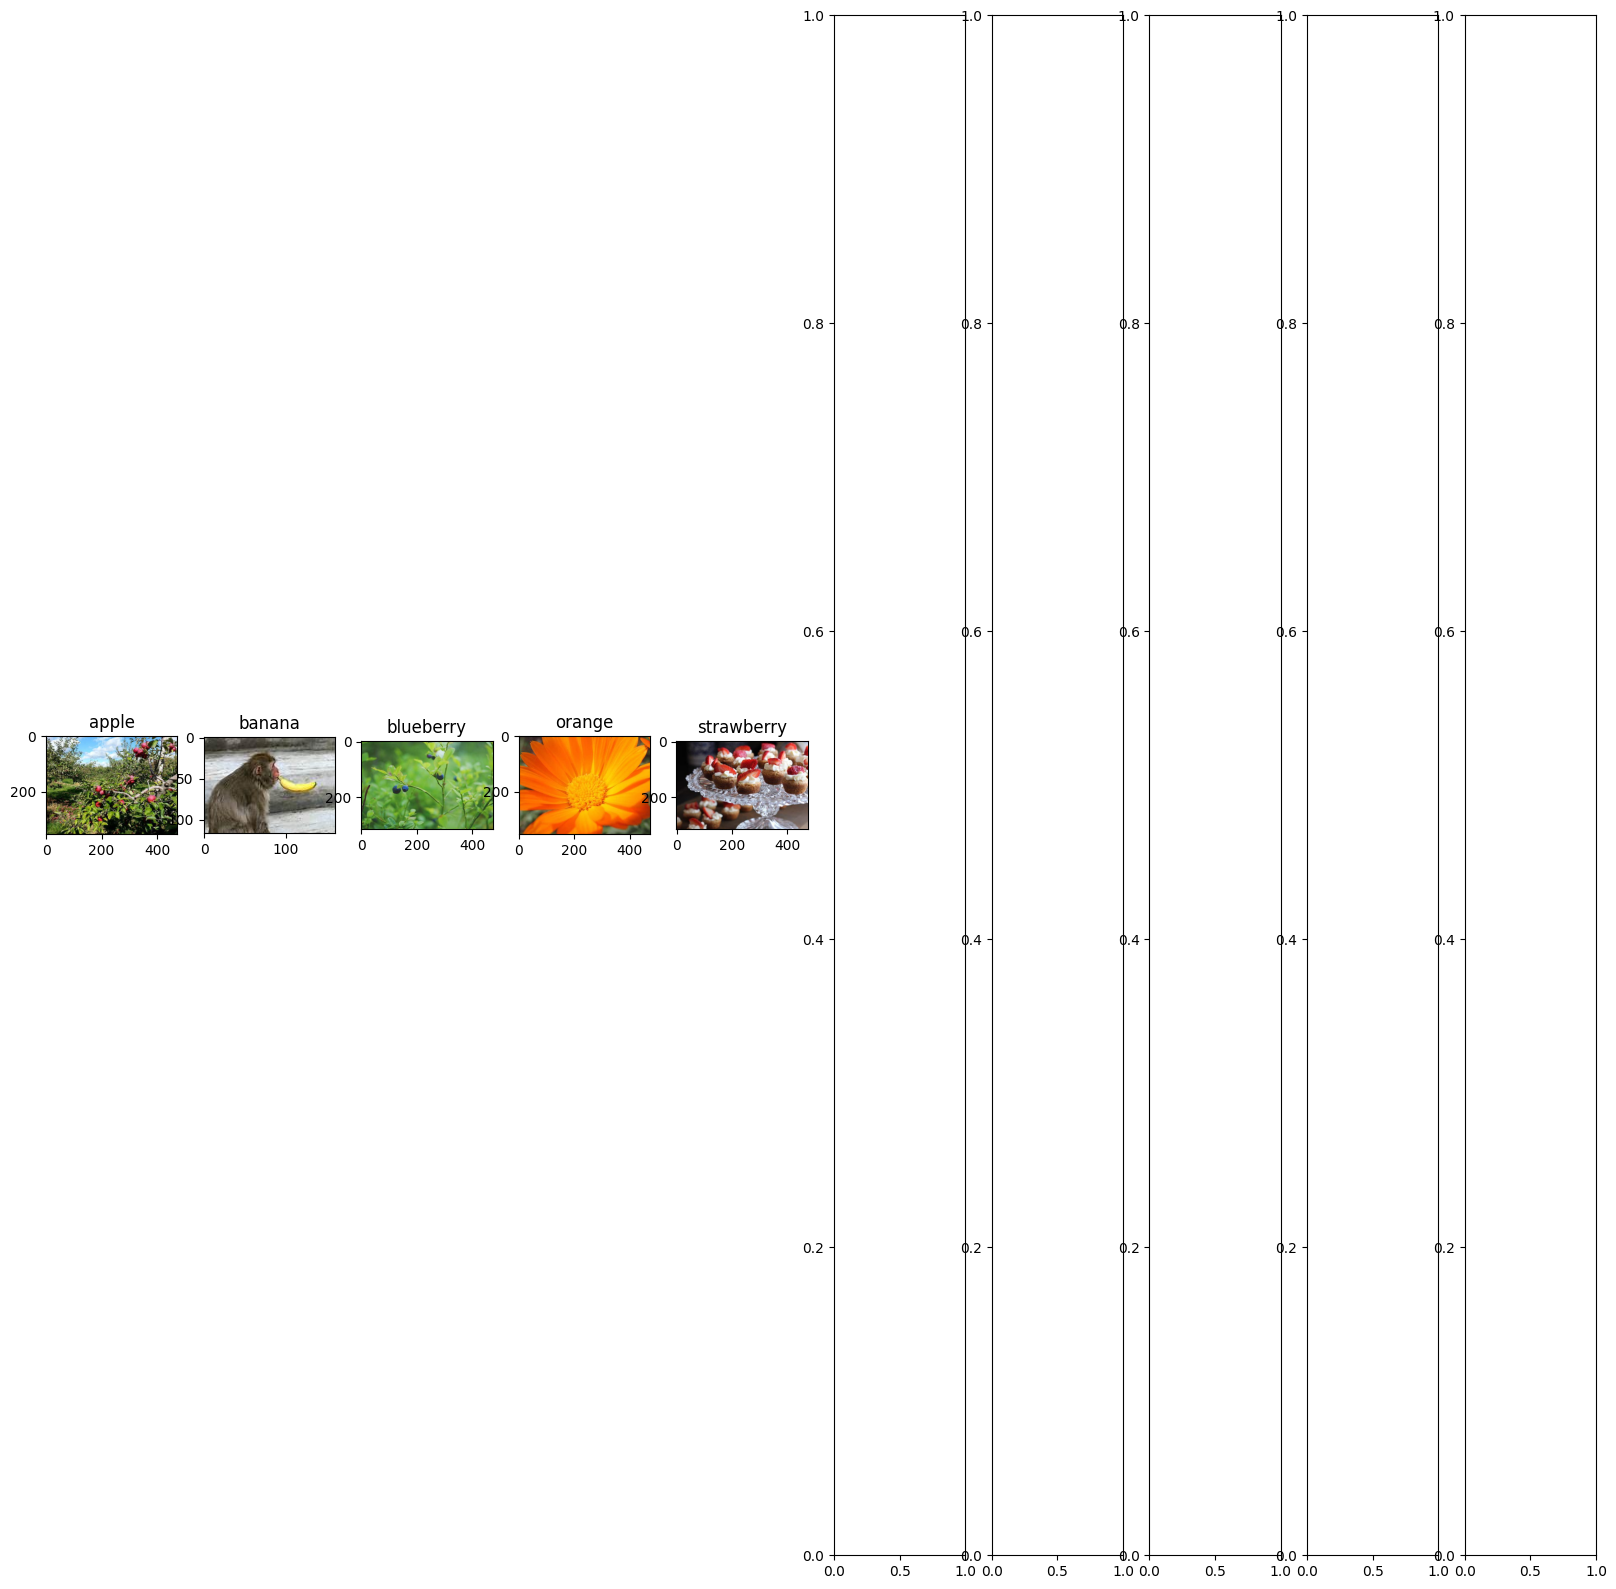

In [21]:
train_folder = '/content/drive/MyDrive/train/'

fig, axs = plt.subplots(1, 10, figsize=(20, 20))

for id, class_folder in enumerate(sorted(os.listdir(train_folder))):

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image)
    axs[id].set_title(class_folder)

In [22]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [23]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [24]:
resnet18_model = resnet18(weights=weights)

if torch.cuda.is_available():
    resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(3, 32, 32))
resnet18_model.modules

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [25]:
for param in resnet18_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [26]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()
                  ])

cifar10_train_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/train', transform=transforms)
cifar10_test_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/validation', transform=transforms)

cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_set, batch_size=32, shuffle=True)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_set, batch_size=32, shuffle=True)

Epoch: 1/20 - Train loss 1.307599 - Train Accuracy 0.537937 - Valid Loss 1.272770 - Valid Accuracy 0.564174
Epoch: 2/20 - Train loss 1.241755 - Train Accuracy 0.600322 - Valid Loss 1.204629 - Valid Accuracy 0.620201
Epoch: 3/20 - Train loss 1.186266 - Train Accuracy 0.632749 - Valid Loss 1.155697 - Valid Accuracy 0.651339
Epoch: 4/20 - Train loss 1.137926 - Train Accuracy 0.665993 - Valid Loss 1.107150 - Valid Accuracy 0.676786
Epoch: 5/20 - Train loss 1.085961 - Train Accuracy 0.701642 - Valid Loss 1.058031 - Valid Accuracy 0.700558
Epoch: 6/20 - Train loss 1.047040 - Train Accuracy 0.717523 - Valid Loss 1.011282 - Valid Accuracy 0.725223
Epoch: 7/20 - Train loss 1.005272 - Train Accuracy 0.739707 - Valid Loss 0.969737 - Valid Accuracy 0.743638
Epoch: 8/20 - Train loss 0.967084 - Train Accuracy 0.754335 - Valid Loss 0.932287 - Valid Accuracy 0.757701
Epoch: 9/20 - Train loss 0.938283 - Train Accuracy 0.762671 - Valid Loss 0.911213 - Valid Accuracy 0.760379
Epoch: 10/20 - Train loss 0.

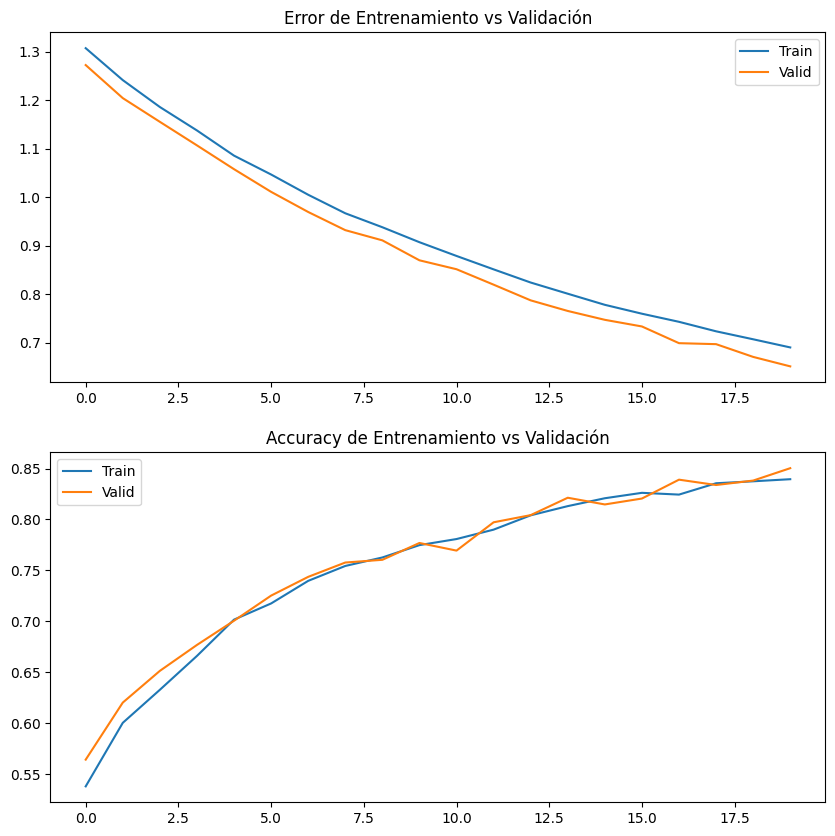

In [37]:
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": cifar10_train_loader, "valid": cifar10_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning/train"),
          "valid": SummaryWriter(log_dir="transfer_learning/valid")}

history = train(resnet18_model.to("cpu"),
                optimizer,
                loss,
                metric,
                data,
                20,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
train_loss2=history["train_loss"]
valid_loss2=history["valid_loss"]
train_acc2=history["train_acc"]
valid_acc2=history["valid_acc"]
axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

AHORA SIGUE VGG19

In [ ]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [ ]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/train', transform=aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/validation', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


In [23]:
vgg19_model = torchvision.models.vgg19(weights=weights)

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
vgg19_model.modules

NameError: ignored

In [ ]:
for param in vgg19_model.parameters():
    param.requires_grad = False

In [ ]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

In [22]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [21]:
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}

history = train(vgg19_model.to("cpu"),
                optimizer,
                loss,
                metric,
                data,
                5,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
train_loss3=history["train_loss"]
valid_loss3=history["valid_loss"]
train_acc3=history["train_acc"]
valid_acc3=history["valid_acc"]
axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

NameError: ignored

In [28]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Carga de datos (Asumiendo que tu estructura de directorios está bien configurada)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   # Aquí puedes agregar más argumentos para data augmentation si lo deseas
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/train',  # directorio de entrenamiento
    target_size=(224, 224),  # Todas las imágenes serán redimensionadas a 224x224
    batch_size=32,
    class_mode='binary')  # Ya que sólo tenemos dos clases, usamos 'binary'

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/validation',  # directorio de validación
    target_size=(224, 224),  # Todas las imágenes serán redimensionadas a 224x224
    batch_size=32,
    class_mode='binary')  # Ya que sólo tenemos dos clases, usamos 'binary'

Found 5997 images belonging to 5 classes.
Found 1255 images belonging to 5 classes.


vgg16

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

# Configurando TensorFlow para usar la CPU
tf.config.set_visible_devices([], 'GPU')

# Verificando que no hay dispositivos GPU disponibles para TensorFlow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Creación del modelo utilizando VGG16
model_vgg16 = tf.keras.Sequential([
    VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # puedes ajustar el rate de dropout según tus necesidades
    layers.Dense(1, activation='sigmoid')
])
# Compilación del modelo
model_vgg16.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])



Num GPUs Available:  1
58889256/58889256 [==============================] - 2s 0us/step


In [30]:
# Entrenamiento del modelo
history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,  # ajusta según tus necesidades
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)




Epoch 1/2
187/187 [==============================] - 8542s 46s/step - loss: nan - accuracy: 0.2045 - val_loss: nan - val_accuracy: 0.2380
Epoch 2/2
187/187 [==============================] - 8689s 46s/step - loss: nan - accuracy: 0.2000 - val_loss: nan - val_accuracy: 0.2372


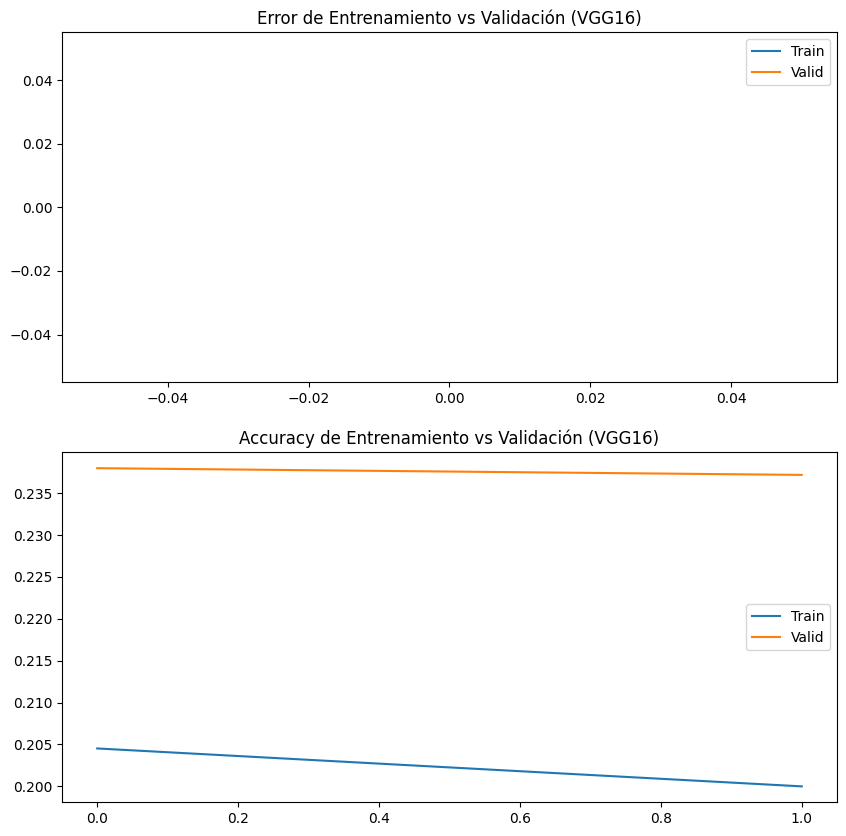

In [31]:
# Visualización de los resultados
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
train_loss3=history_vgg16.history["loss"]
valid_loss3=history_vgg16.history["val_loss"]
train_acc3=history_vgg16.history["accuracy"]
valid_acc3=history_vgg16.history["val_accuracy"]
axs[0].plot(history_vgg16.history["loss"])
axs[0].plot(history_vgg16.history["val_loss"])
axs[0].set_title('Error de Entrenamiento vs Validación (VGG16)')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history_vgg16.history["accuracy"])
axs[1].plot(history_vgg16.history["val_accuracy"])
axs[1].set_title('Accuracy de Entrenamiento vs Validación (VGG16)')
axs[1].legend(['Train', 'Valid'])

plt.show()

ahora inceptionv3

In [32]:
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Num GPUs Available:  1
87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/2
187/187 [==============================] - 2277s 12s/step - loss: -163.1076 - accuracy: 0.2292 - val_loss: -3296.4802 - val_accuracy: 0.1210
Epoch 2/2
187/187 [==============================] - 2286s 12s/step - loss: -747.1626 - accuracy: 0.2248 - val_loss: -1689.2743 - val_accuracy: 0.1194


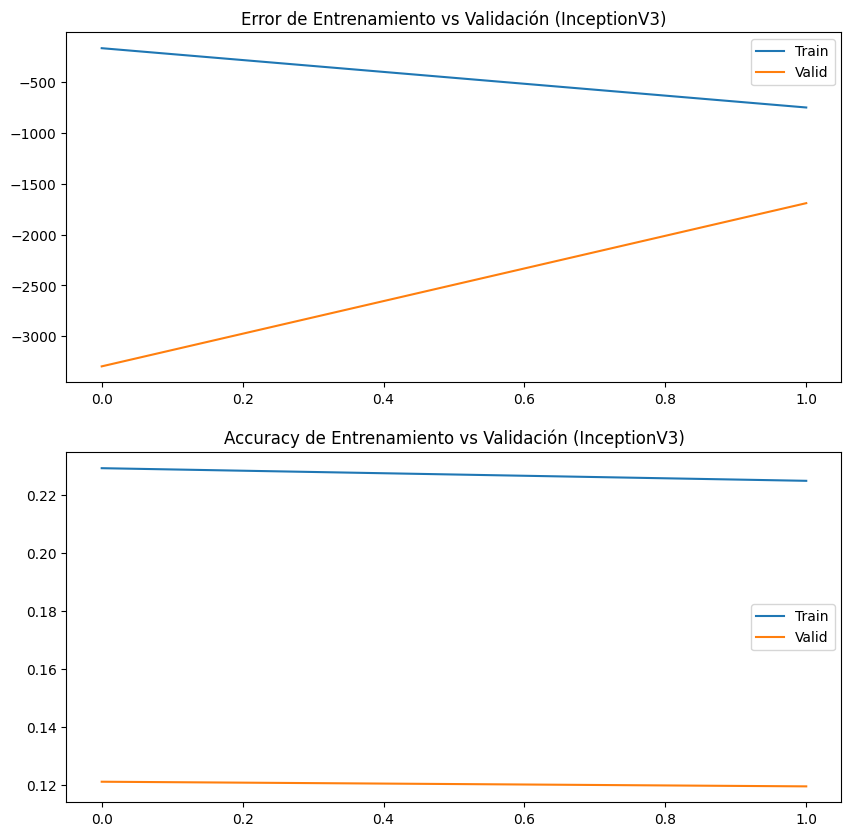

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers

# Configurando TensorFlow para usar la CPU
tf.config.set_visible_devices([], 'GPU')

# Verificando que no hay dispositivos GPU disponibles para TensorFlow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Crear el modelo utilizando InceptionV3
model_incep = tf.keras.Sequential([
    InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])



# Compilar el modelo
model_incep.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Entrenar el modelo
history_incep = model_incep.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,  # ajusta según tus necesidades
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

# Visualizar los resultados
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history_incep.history["loss"])
axs[0].plot(history_incep.history["val_loss"])
axs[0].set_title('Error de Entrenamiento vs Validación (InceptionV3)')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history_incep.history["accuracy"])
axs[1].plot(history_incep.history["val_accuracy"])
axs[1].set_title('Accuracy de Entrenamiento vs Validación (InceptionV3)')
axs[1].legend(['Train', 'Valid'])

plt.show()

In [34]:
train_loss4=history_incep.history["loss"]
valid_loss4=history_incep.history["val_loss"]
train_acc4=history_incep.history["accuracy"]
valid_acc4=history_incep.history["val_accuracy"]

In [42]:
print(train_loss2)
print(valid_loss2)
print(train_acc2)
print(valid_acc2)
print("-----")
print(train_loss3)
print(valid_loss3)
print(train_acc3)
print(valid_acc3)
print("-----")
print(train_loss4)
print(valid_loss4)
print(train_acc4)
print(valid_acc4)

[1.3075991012948625, 1.2417550841544538, 1.186265989821008, 1.1379256505281368, 1.0859609097242355, 1.047040008167003, 1.005272259103491, 0.9670839893056992, 0.9382832601983496, 0.9074061779265709, 0.8790492000097924, 0.8514078440184288, 0.8242227178304753, 0.8011458893405631, 0.7782512529099241, 0.7599157706854192, 0.743188849789031, 0.7236108095087903, 0.707171766523351, 0.6903605605376527]
[1.2727700084447862, 1.20462866127491, 1.1556974440813064, 1.1071496248245238, 1.0580306187272073, 1.0112820759415626, 0.9697373375296593, 0.9322869807481766, 0.9112129762768746, 0.8700632497668266, 0.8516607269644737, 0.8198321908712387, 0.7874401152133942, 0.7655860736966134, 0.7473060265183449, 0.7336110919713974, 0.6991434022784233, 0.6971197620034217, 0.6708236455917358, 0.6512971580028534]
[0.5379372955636775, 0.6003222177003292, 0.6327485679946048, 0.6659932488456686, 0.7016417758261904, 0.7175225041648174, 0.7397069354006585, 0.7543345949751266, 0.762671338116869, 0.7747928601630191, 0.780

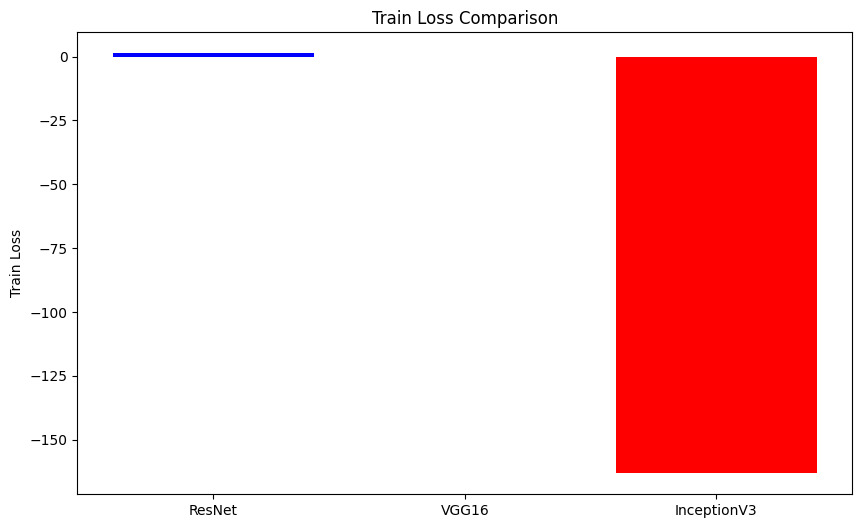

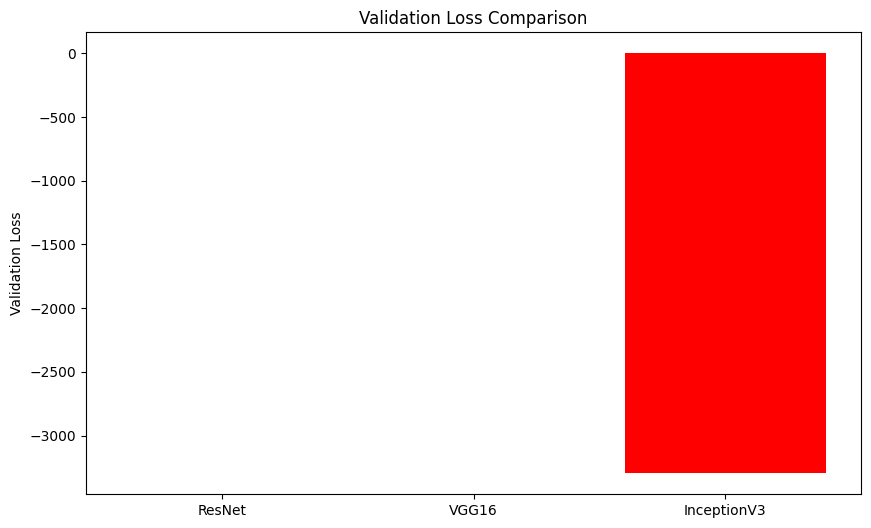

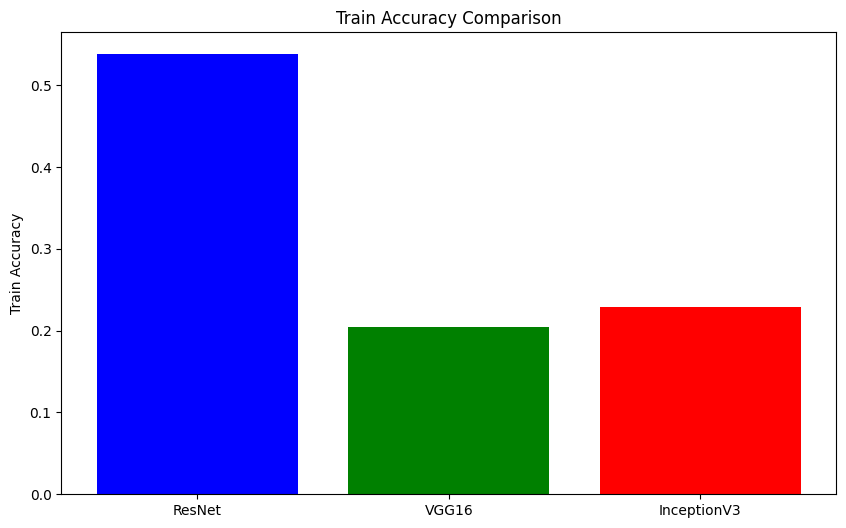

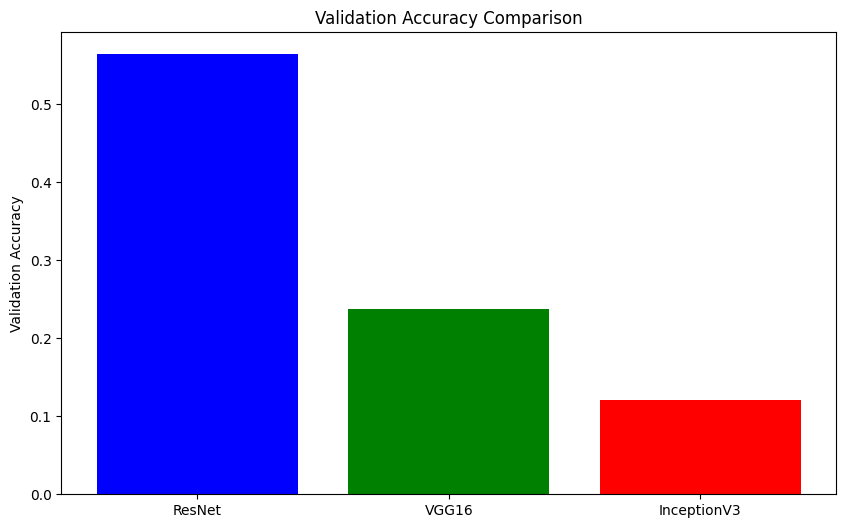

ResNet Metrics:
  Train Loss: 1.3075991012948625
  Validation Loss: 1.2727700084447862
  Train Accuracy: 0.5379372955636775
  Validation Accuracy: 0.5641741074621678

VGG16 Metrics:
  Train Loss: nan
  Validation Loss: nan
  Train Accuracy: 0.2045264095067978
  Validation Accuracy: 0.23798076808452606

InceptionV3 Metrics:
  Train Loss: -163.1075897216797
  Validation Loss: -3296.480224609375
  Train Accuracy: 0.22917015850543976
  Validation Accuracy: 0.12099359184503555



In [44]:
import matplotlib.pyplot as plt

# Supongamos que tienes las siguientes métricas hipotéticas después de entrenar tus modelos.
metrics_resnet = {
    "train_loss": train_loss2[0],
    "valid_loss":valid_loss2[0],
    "train_acc": train_acc2[0],
    "valid_acc": valid_acc2[0]
}

metrics_vgg16 = {
    "train_loss": train_loss3[0],
    "valid_loss":valid_loss3[0],
    "train_acc": train_acc3[0],
    "valid_acc": valid_acc3[0]
}

metrics_inception = {
    "train_loss": train_loss4[0],
    "valid_loss":valid_loss4[0],
    "train_acc": train_acc4[0],
    "valid_acc": valid_acc4[0]
}

# Nombres y métricas de los modelos
model_names = ['ResNet', 'VGG16', 'InceptionV3']
train_losses = [metrics_resnet['train_loss'], metrics_vgg16['train_loss'], metrics_inception['train_loss']]
valid_losses = [metrics_resnet['valid_loss'], metrics_vgg16['valid_loss'], metrics_inception['valid_loss']]
train_accuracies = [metrics_resnet['train_acc'], metrics_vgg16['train_acc'], metrics_inception['train_acc']]
valid_accuracies = [metrics_resnet['valid_acc'], metrics_vgg16['valid_acc'], metrics_inception['valid_acc']]

# Función para crear un gráfico de barras para comparar las métricas de los modelos
def plot_bar(metric_values, metric_name):
    plt.figure(figsize=(10,6))
    plt.bar(model_names, metric_values, color=['blue', 'green', 'red'])
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison')
    plt.show()

# Graficar cada métrica
plot_bar(train_losses, 'Train Loss')
plot_bar(valid_losses, 'Validation Loss')
plot_bar(train_accuracies, 'Train Accuracy')
plot_bar(valid_accuracies, 'Validation Accuracy')

# Puedes imprimir y comparar los valores directamente si eso también es útil
for model, train_loss, valid_loss, train_acc, valid_acc in zip(model_names, train_losses, valid_losses, train_accuracies, valid_accuracies):
    print(f"{model} Metrics:\n  Train Loss: {train_loss}\n  Validation Loss: {valid_loss}\n  Train Accuracy: {train_acc}\n  Validation Accuracy: {valid_acc}\n")


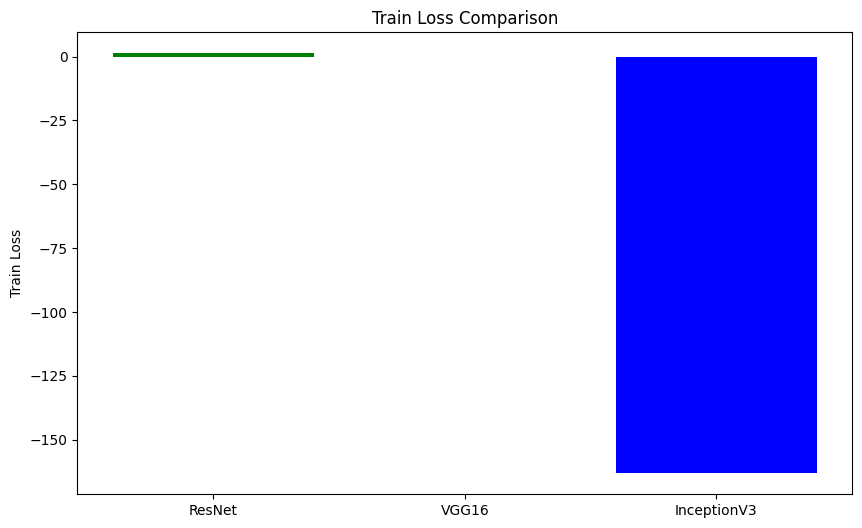

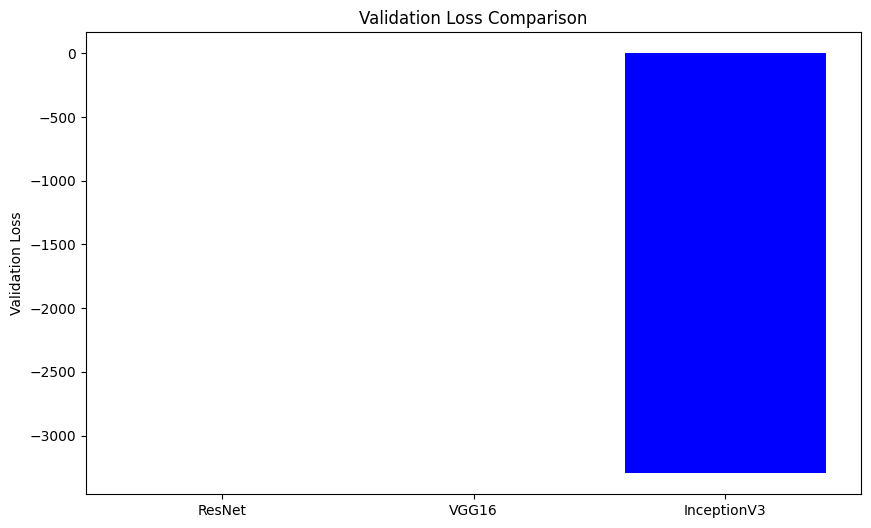

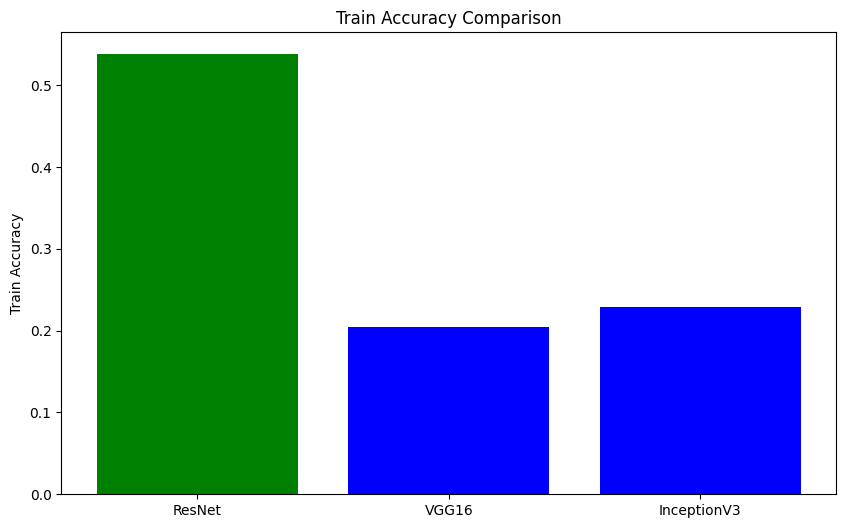

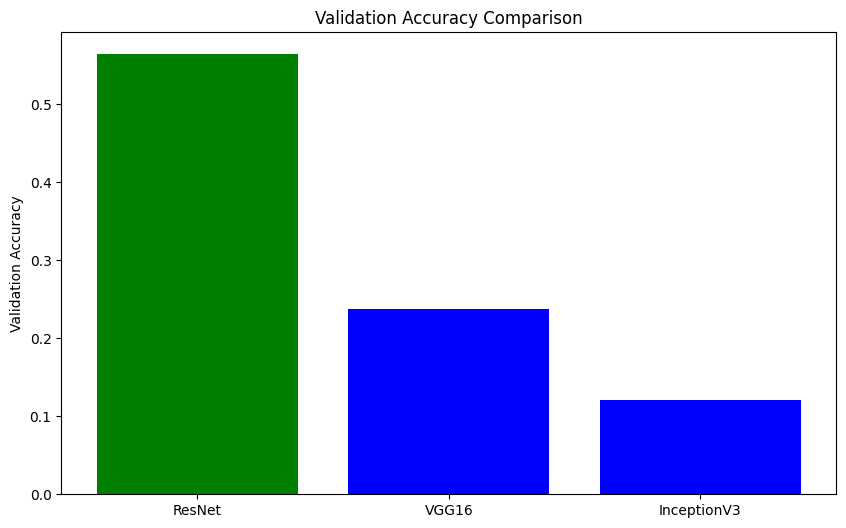

ResNet Metrics:
  Train Loss: 1.3075991012948625
  Validation Loss: 1.2727700084447862
  Train Accuracy: 0.5379372955636775
  Validation Accuracy: 0.5641741074621678

VGG16 Metrics:
  Train Loss: nan
  Validation Loss: nan
  Train Accuracy: 0.2045264095067978
  Validation Accuracy: 0.23798076808452606

InceptionV3 Metrics:
  Train Loss: -163.1075897216797
  Validation Loss: -3296.480224609375
  Train Accuracy: 0.22917015850543976
  Validation Accuracy: 0.12099359184503555

Best Train Loss: ResNet
Best Validation Loss: ResNet
Best Train Accuracy: ResNet
Best Validation Accuracy: ResNet


In [45]:
import matplotlib.pyplot as plt


# Función para crear un gráfico de barras para comparar las métricas de los modelos
def plot_bar(metric_values, metric_name, best_idx=None):
    plt.figure(figsize=(10,6))
    colors = ['blue' if idx != best_idx else 'green' for idx in range(len(metric_values))]
    plt.bar(model_names, metric_values, color=colors)
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison')
    plt.show()

# Función para obtener el índice del mejor valor de una métrica
def get_best_metric_index(metric_values, metric_name):
    return metric_values.index(min(metric_values)) if "loss" in metric_name else metric_values.index(max(metric_values))

# Graficar cada métrica con el mejor modelo resaltado en verde
plot_bar(train_losses, 'Train Loss', get_best_metric_index(train_losses, 'Train Loss'))
plot_bar(valid_losses, 'Validation Loss', get_best_metric_index(valid_losses, 'Validation Loss'))
plot_bar(train_accuracies, 'Train Accuracy', get_best_metric_index(train_accuracies, 'Train Accuracy'))
plot_bar(valid_accuracies, 'Validation Accuracy', get_best_metric_index(valid_accuracies, 'Validation Accuracy'))

# Imprimir y comparar los valores directamente
for model, train_loss, valid_loss, train_acc, valid_acc in zip(model_names, train_losses, valid_losses, train_accuracies, valid_accuracies):
    print(f"{model} Metrics:\n  Train Loss: {train_loss}\n  Validation Loss: {valid_loss}\n  Train Accuracy: {train_acc}\n  Validation Accuracy: {valid_acc}\n")

# Imprimir cuál modelo tiene la mejor métrica en cada categoría
print(f"Best Train Loss: {model_names[get_best_metric_index(train_losses, 'Train Loss')]}\n"
      f"Best Validation Loss: {model_names[get_best_metric_index(valid_losses, 'Validation Loss')]}\n"
      f"Best Train Accuracy: {model_names[get_best_metric_index(train_accuracies, 'Train Accuracy')]}\n"
      f"Best Validation Accuracy: {model_names[get_best_metric_index(valid_accuracies, 'Validation Accuracy')]}")


---
## TensorBoard

Otra forma de visualizar los resultados del entrenamiento de nuestra red es mediante la herramienta TensorBoard, la cual forma parte del framework de Tensorflow. Esta herramienta nos permite ver graficas interactivas de la evolución de las distintas metricas a lo largo de las epocas o las iteraciones de entrenamiento, así como también un grafo de las conexiones que componen nuestro modelo, entre otras cosas.

Tensorboard cuenta con una plataforma gratuita, llamada [Tensorboard.dev](https://tensorboard.dev/) donde podemos subir los resultados de nuestros experimentos, es decir, los archivos de Tensorboard generados por nuestro entrenamiento. De esta forma logramos un almacenamiento persistente de dichos resultados, que puede compartirse y compararse de forma mas sencilla a traves de un navegador desde cualquier lugar.

Para poder utilizar la plataforma debemos estar loggeados en una cuenta de google y acceder a este link: https://tensorboard.dev/experiments/. Luego, desde Colab, estando loggeados con la misma cuenta de google, el procedimiento es sencillo. Se debe ejecutar un comando como el siguiente, en donde se indica el path donde se encuentran los archivos con los experimentos, un nombre para almacenarlos y una descripcion.